In [1]:
import wave
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal.windows import hann
from tqdm import tqdm

In [3]:
# Separate channels
fs, data = wavfile.read("C Major Chord Piano Keyboard Demo.wav")

wavfile.write('ch_1.wav', fs, data[:, 0])
wavfile.write('ch_2.wav', fs, data[:, 1])

"nchannels --> mono or stereo",

"sampwidtth --> bytes per sample",

"framerate --> frames per second - WAV files are a sequence of frames",

"nframes --> total frames"

In [4]:
def load_wav(file_path):
    wav = wave.open(file_path)
    raw = wav.readframes(-1) # reads every frame from the song
    fs = wav.getframerate()
    signal = np.frombuffer(raw, 'int16')
    print(f'Params for {file_path}')
    print(wav.getparams())
    return signal, fs

In [5]:
signal_1, fs_1 = load_wav("ch_1.wav")
signal_2, fs_2 = load_wav("ch_2.wav")

Params for ch_1.wav
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=348300, comptype='NONE', compname='not compressed')
Params for ch_2.wav
_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=348300, comptype='NONE', compname='not compressed')


In [6]:
print(f'Max: {signal_1.max()}')
print(f'Min: {signal_2.min()}')

Max: 22323
Min: -21265


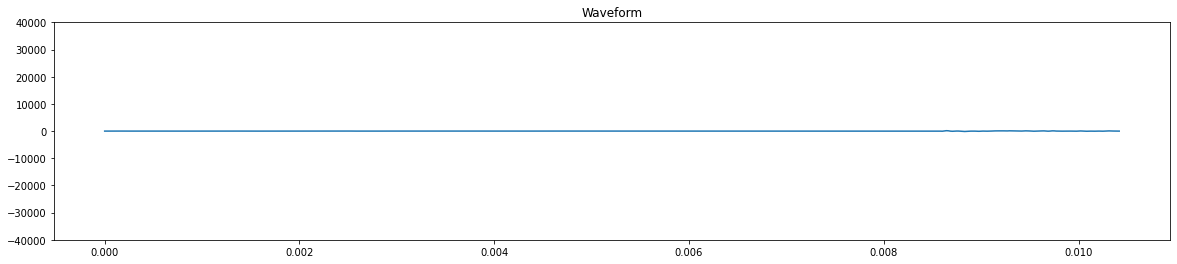

48000

In [7]:
def plot_wav(signal, fs, min=-40000, max=40000):
    time = np.linspace(0, len(signal)/fs, num=len(signal))

    plt.figure(figsize=(20, 4))
    plt.title('Waveform')
    plt.plot(time, signal)
    plt.ylim(min, max)
    plt.show()
    
    return fs
    
plot_wav(signal_1[3000:3500], fs_1)

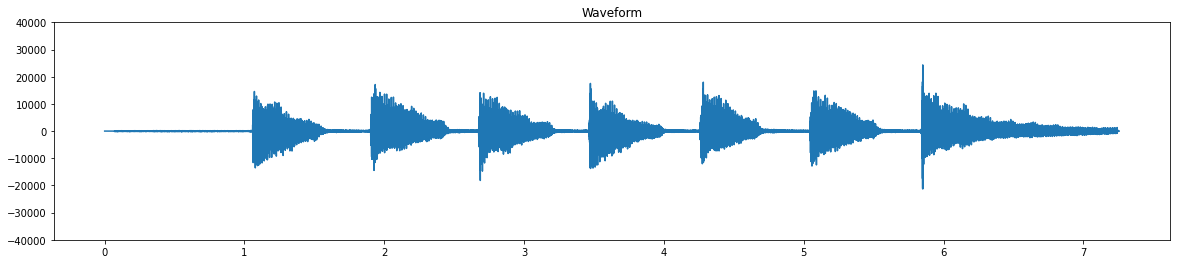

48000

In [8]:
plot_wav(signal_2, fs_2)

# FT

## Spectral Leakage

Occurs when there isn't an integer number of periods in the waveform, i.e. there's a discontinuity between the start and end of the waveform. Shows up as areas of high frequency in the FT (they "leak" into the hiigher frequency of the FT)

In [9]:
ft_1 = fft(signal_1)
ft_1 = np.abs(ft_1)
ft_2 = fft(signal_2)
ft_2 = np.abs(ft_2)


<AxesSubplot:>

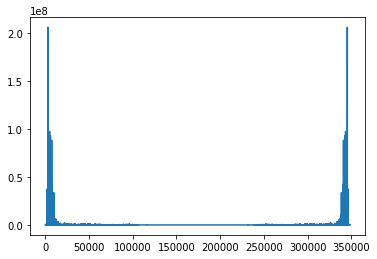

In [10]:
sns.lineplot(x=range(len(ft_1)), y=ft_1)

<AxesSubplot:>

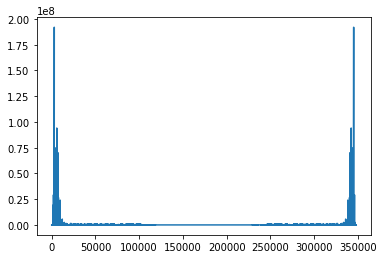

In [11]:
sns.lineplot(x=range(len(ft_2)), y=ft_2)

## Removing Spectral Leakage

Do this by windowing. Apply a windowing function to each frame before feating into the FT.

Hann window

$$w(n) =  0.5 * (1- cos(\frac{2\pi n}{M-1})), 0 \leq n \leq M-1$$

For sample n. To get the windowed signal

$$s_w(n) = s(n)*w(n) , 0 \leq n \leq M-1$$

Text(0.5, 1.0, 'An Example Han Window with 51 Points')

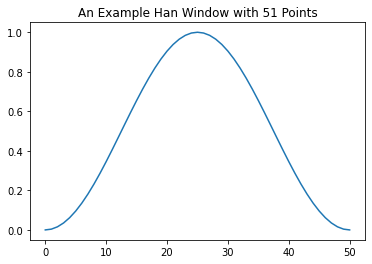

In [12]:
sns.lineplot(x=range(51), y=hann(51))
plt.title('An Example Han Window with 51 Points')

Text(0.5, 1.0, 'After Windowing')

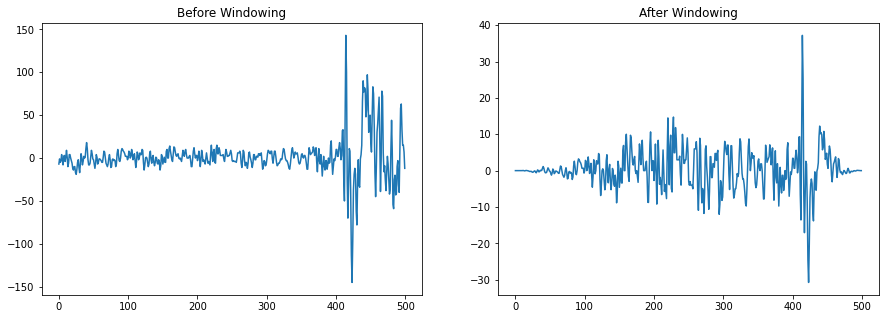

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
subset = signal_1[3000:3500]
window = hann(len(subset))

s_w = [sample*window[i] for i, sample in enumerate(subset)]

sns.lineplot(x=range(len(subset)), y=subset, ax=axes[0])
axes[0].set_title('Before Windowing')

sns.lineplot(x=range(len(subset)), y=s_w, ax=axes[1])
axes[1].set_title('After Windowing')

Note that the discontinuity at the end goes away. But you lose signal at the end of each frame.

The solution to signal loss is to have frames that overlap. Each frame has a frame size K. After getting all of the frames in a sample, you shift right by the "hop size."

In [14]:
def hann_windowing(frame):
    '''
    Applies Hann windowing to a frame.
    '''
    window = hann(len(frame))
    s_w = [sample*window[i] for i, sample in enumerate(frame)]
    return s_w


In [15]:
def frames(signal, frame_width, hop_size):
    max_idx = len(signal) - frame_width
    frame_out = np.zeros(len(signal))
    for i in tqdm(range(0, max_idx, hop_size)):
        frame = signal[i:i+frame_width]
        frame_out[i:i+frame_width] += hann_windowing(frame)
        
    return frame_out

In [16]:
s_w = frames(signal_1, 3, 2)

100%|██████████| 174149/174149 [00:05<00:00, 31587.94it/s]


Text(0.5, 1.0, 'After Windowing')

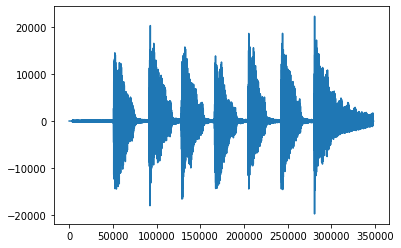

In [17]:
sns.lineplot(x=range(len(s_w)), y=s_w)
axes[1].set_title('After Windowing')

<AxesSubplot:>

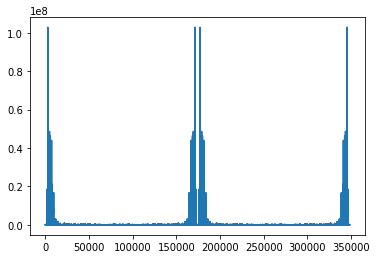

In [18]:
ft_1 = fft(s_w)
ft_1 = np.abs(ft_1)
sns.lineplot(x=range(len(ft_1)), y=ft_1)

# ICA

In [19]:
X = list(zip(signal_1, signal_2))
X = np.asarray(X)

In [20]:
X.shape, signal_1.shape

((348300, 2), (348300,))

In [21]:
ica = FastICA(n_components=2, whiten_solver='svd', max_iter=100)
song_decomp = ica.fit_transform(X)

c:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [22]:
decomp_1 = song_decomp[:,0]
decomp_2 = song_decomp[:,1]

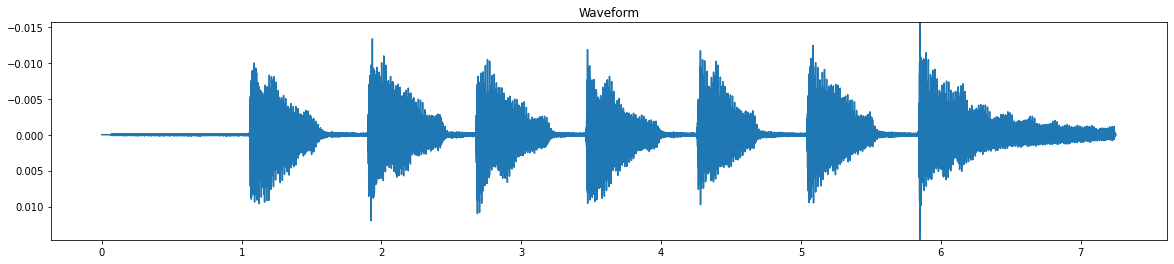

48000

In [23]:
plot_wav(decomp_1, fs_1, decomp_1.max(), decomp_1.min())

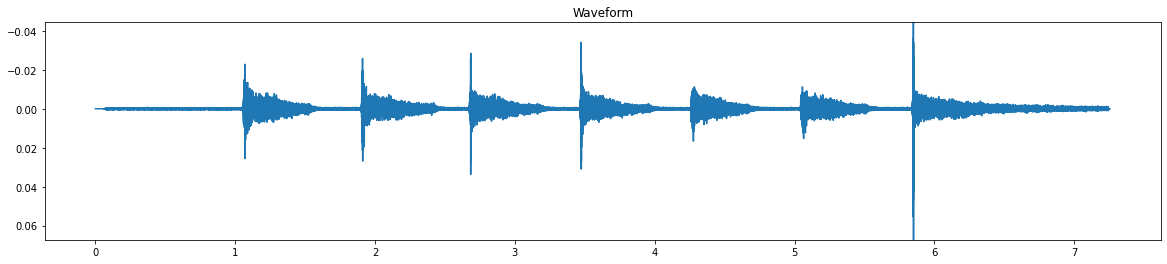

48000

In [24]:
plot_wav(decomp_2, fs_1, decomp_2.max(), decomp_2.min())

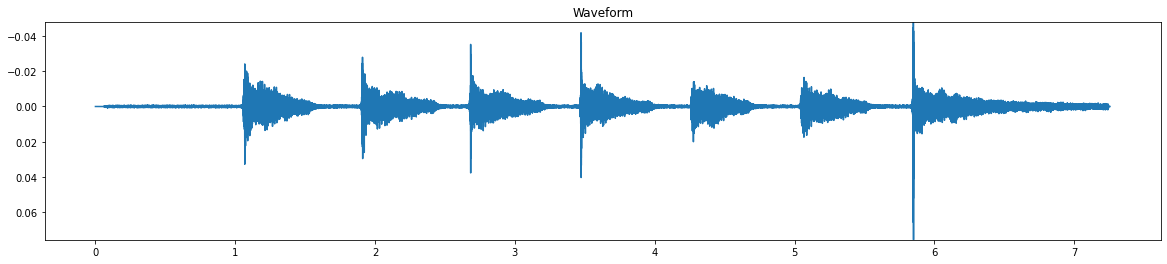

48000

In [25]:
diff = decomp_2 - decomp_1
plot_wav(diff, fs_1, diff.max(), diff.min())

In [26]:
def write_wav(decomp_component, fs, name):
    # Scale to amplitude range for int16 audio
    scaled = np.int16(decomp_component*32767*100)
    wavfile.write(name+'.wav', fs, scaled)

In [27]:
write_wav(decomp_1, fs_1, 'component_1')
write_wav(decomp_2, fs_1, 'component_2')
write_wav(diff, fs_1, 'difference')

In [28]:
write_wav(s_w, fs_1, 'windowed')
